<a href="https://colab.research.google.com/github/Dharamchandpatle/Refinery-AIML/blob/main/AI_Driven_Smart_Refinery_Intelligence_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AI-Driven Smart Refinery Intelligence System

In [3]:
# INSTALL DEPENDENCIES
# !pip install prophet


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error, mean_squared_error

from prophet import Prophet
from google.colab import files
import smtplib
from email.message import EmailMessage


In [5]:
# UPLOAD DATASET (AUTOMATION TRIGGER 🔥)


uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

print("Dataset uploaded:", file_name)
df.head()

Saving 1refinery_energy_large_dataset.csv to 1refinery_energy_large_dataset.csv
Dataset uploaded: 1refinery_energy_large_dataset.csv


,date,unit_name,electricity_kwh,steam_usage,fuel_usage,production_tons,SEC
0,21-10-2023 03:00,Hydrocracker,876.896024,451.883508,315.944364,129.774212,12.673734
1,05-02-2022 20:00,CDU,892.363227,583.108649,366.385274,151.946967,12.121711
2,06-10-2030 20:00,DCU,1038.607058,554.011158,157.918743,136.168086,12.855707
3,05-04-2028 22:00,CDU,808.311888,680.183209,304.637560,138.340268,12.961755
4,19-09-2022 01:00,CDU,997.376810,490.170735,337.180859,141.055837,12.936213


In [6]:
# ROBUST DATA CLEANING + COLUMN AUTO-MAPPING (CRITICAL)


# Remove duplicates
df.drop_duplicates(inplace=True)

# Handle date safely
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df[df["date"].notna()]

# ---- Column auto-mapping ----
column_map = {
    "electricity_kwh": ["electricity_kwh", "electricity", "elec_kwh", "power_kwh", "energy_kwh"],
    "steam_usage": ["steam_usage", "steam", "steam_kwh"],
    "fuel_usage": ["fuel_usage", "fuel", "fuel_kwh"],
    "production_tons": ["production_tons", "production", "output_tons"]
}

for standard_col, possible_cols in column_map.items():
    for col in possible_cols:
        if col in df.columns:
            df[standard_col] = df[col]
            break

required_cols = list(column_map.keys())
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Handle missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Remove impossible values
df = df[
    (df["electricity_kwh"] > 0) &
    (df["steam_usage"] > 0) &
    (df["fuel_usage"] > 0) &
    (df["production_tons"] > 0)
]

print("Data cleaning & column mapping completed")
df.info()

Data cleaning & column mapping completed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             100000 non-null  datetime64[ns]
 1   unit_name        100000 non-null  object        
 2   electricity_kwh  100000 non-null  float64       
 3   steam_usage      100000 non-null  float64       
 4   fuel_usage       100000 non-null  float64       
 5   production_tons  100000 non-null  float64       
 6   SEC              100000 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 5.3+ MB


/tmp/ipython-input-1013092502.py:9: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["date"] = pd.to_datetime(df["date"], errors="coerce")


In [7]:
# FEATURE ENGINEERING (SEC & TOTAL ENERGY)


df["total_energy"] = (
    df["electricity_kwh"] +
    df["steam_usage"] +
    df["fuel_usage"]
)

df["SEC"] = df["total_energy"] / df["production_tons"]
df.head()

,date,unit_name,electricity_kwh,steam_usage,fuel_usage,production_tons,SEC,total_energy
0,2023-10-21 03:00:00,Hydrocracker,876.896024,451.883508,315.944364,129.774212,12.673734,1644.723895
1,2022-02-05 20:00:00,CDU,892.363227,583.108649,366.385274,151.946967,12.121711,1841.857150
2,2030-10-06 20:00:00,DCU,1038.607058,554.011158,157.918743,136.168086,12.855707,1750.536959
3,2028-04-05 22:00:00,CDU,808.311888,680.183209,304.637560,138.340268,12.961755,1793.132657
4,2022-09-19 01:00:00,CDU,997.376810,490.170735,337.180859,141.055837,12.936213,1824.728404


Model 1  : ANOMALY DETECTION (ISOLATION FOREST)


In [8]:
#  TRAIN MODEL

features = [
    "electricity_kwh",
    "steam_usage",
    "fuel_usage",
    "production_tons",
    "SEC"
]

X = df[features]

iso_model = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)

iso_model.fit(X)
df["anomaly"] = np.where(iso_model.predict(X) == -1, 1, 0)

In [9]:
# SEVERITY ASSIGNMENT


SEC_MEAN = df["SEC"].mean()

def severity(sec):
    if sec > 1.5 * SEC_MEAN:
        return "HIGH"
    elif sec > 1.2 * SEC_MEAN:
        return "MEDIUM"
    elif sec > SEC_MEAN:
        return "LOW"
    else:
        return "NORMAL"

df["severity"] = df["SEC"].apply(severity)

MODEL 2: ENERGY & SEC PREDICTION (PROPHET)

In [10]:
# DAILY AGGREGATION


daily_df = df.groupby("date").agg({
    "total_energy": "sum",
    "SEC": "mean"
}).reset_index()

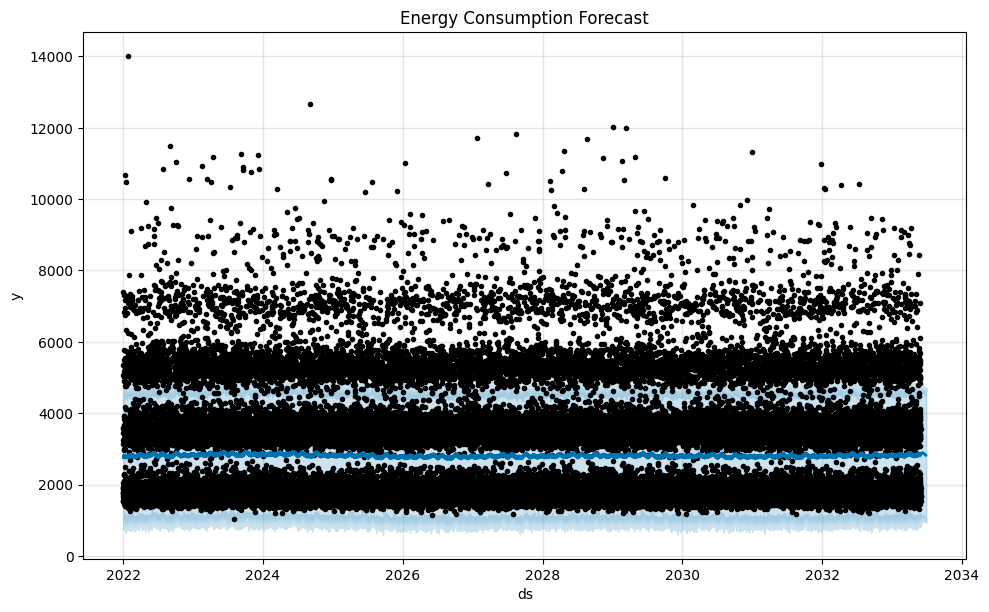

In [11]:
# ENERGY FORECAST

energy_ts = daily_df.rename(columns={"date": "ds", "total_energy": "y"})

energy_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    changepoint_prior_scale=0.1
)
energy_model.fit(energy_ts)

future_energy = energy_model.make_future_dataframe(periods=30)
energy_forecast = energy_model.predict(future_energy)

energy_model.plot(energy_forecast)
plt.title("Energy Consumption Forecast")
plt.show()

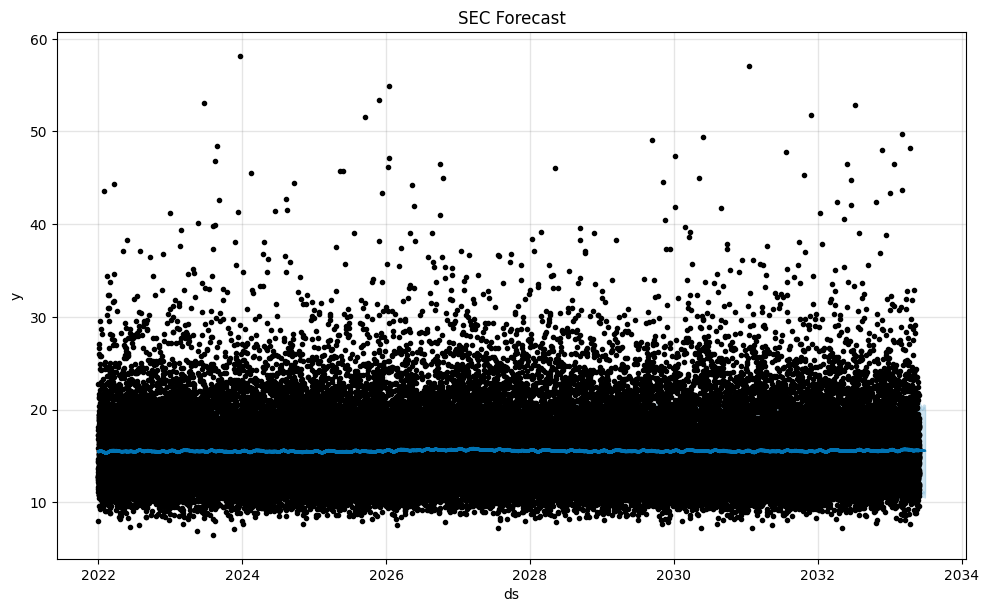

In [12]:
# SEC FORECAST (EFFICIENCY TREND)


sec_ts = daily_df.rename(columns={"date": "ds", "SEC": "y"})

sec_model = Prophet(
    yearly_seasonality=True,
    changepoint_prior_scale=0.1
)
sec_model.fit(sec_ts)

future_sec = sec_model.make_future_dataframe(periods=30)
sec_forecast = sec_model.predict(future_sec)

sec_model.plot(sec_forecast)
plt.title("SEC Forecast")
plt.show()

In [13]:
# OPTIONAL FORECAST VALIDATION

actual = energy_ts.tail(30)["y"].values
predicted = energy_forecast.tail(30)["yhat"].values

mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 1271.3292667646738
RMSE: 1442.8611965152259


MODEL 3: RECOMMENDATION SYSTEM

In [14]:
# GENERATE RECOMMENDATIONS


def recommendation(row):
    if row["severity"] == "HIGH":
        return "Immediate action: reduce load, inspect equipment"
    elif row["severity"] == "MEDIUM":
        return "Optimize parameters and steam usage"
    elif row["severity"] == "LOW":
        return "Preventive optimization"
    else:
        return "Operation normal"

df["recommendation"] = df.apply(recommendation, axis=1)

In [15]:
# FINAL DECISION TABLE

decision_table = df[[
    "date",
    "severity",
    "SEC",
    "recommendation"
]]

decision_table.head()

,date,severity,SEC,recommendation
0,2023-10-21 03:00:00,NORMAL,12.673734,Operation normal
1,2022-02-05 20:00:00,NORMAL,12.121711,Operation normal
2,2030-10-06 20:00:00,NORMAL,12.855707,Operation normal
3,2028-04-05 22:00:00,NORMAL,12.961755,Operation normal
4,2022-09-19 01:00:00,NORMAL,12.936213,Operation normal


In [16]:
# SAVE FILES

energy_forecast.to_csv("energy_forecast.csv", index=False)
sec_forecast.to_csv("sec_forecast.csv", index=False)
decision_table.to_csv("optimization_recommendations.csv", index=False)

print("All files saved")

All files saved


In [17]:
# DOWNLOAD FILES

# files.download("energy_forecast.csv")
# files.download("sec_forecast.csv")
# files.download("optimization_recommendations.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
# Compress files into ONE ZIP
import zipfile

zip_filename = "refinery_reports.zip"

with zipfile.ZipFile(zip_filename, "w", zipfile.ZIP_DEFLATED) as zipf:
    zipf.write("energy_forecast.csv")
    zipf.write("sec_forecast.csv")
    zipf.write("optimization_recommendations.csv")

print("ZIP file created")


ZIP file created


In [21]:
from email.message import EmailMessage
import smtplib

EMAIL = "dharambaba2k4@gmail.com"
APP_PASSWORD = "fugmkuhfxtzeutjm"

msg = EmailMessage()
msg["Subject"] = "Automated Refinery Energy & Optimization Report"
msg["From"] = EMAIL
msg["To"] = "dharamcodemystery@gmail.com"
msg.set_content(
    "Attached is the compressed refinery energy forecast and optimization report."
)

with open(zip_filename, "rb") as f:
    msg.add_attachment(
        f.read(),
        maintype="application",
        subtype="zip",
        filename=zip_filename
    )

with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
    server.login(EMAIL, APP_PASSWORD)
    server.send_message(msg)

print("Email sent successfully with ZIP attachment")


Email sent successfully with ZIP attachment


In [22]:
# In real industry, nobody emails raw 5-year data.

# Create summary instead:
summary_df = decision_table.groupby("severity").size().reset_index(name="count")
summary_df.to_csv("summary_report.csv", index=False)